<img src=Python专栏课.jpg width="30%">
# Shifterator text analysis on Animal Crossing reviews

I saw a tweet from [Ryan J. Gallagher](https://twitter.com/ryanjgallag) about his new Python package for people who hate wordclouds called "Shifterator". From his GitHub repo:

> _The Shifterator package provides functionality for constructing word shift graphs, vertical bart charts that quantify which words contribute to a pairwise difference between two texts and how they contribute. By allowing you to look at changes in how words are used, word shifts help you to conduct analyses of sentiment, entropy, and divergence that are fundamentally more interpretable._

I decided to try out this new package on this week's TidyTuesday dataset on [Animal Crossing](https://www.kaggle.com/jessemostipak/animal-crossing). I'm definitely more of an #rstats person where I'm a huge fan of Dr. Julia Silge and David Robinson's [TidyText package](https://www.tidytextmining.com/). But Shifterator looked intriguing enough for me to dust off my rusty Python skills (or lack thereof). Anyway, so apologies if my Python code looks terrible. Let me know in the comments what I should fix.

In [1]:
!pip install shifterator

In [2]:
# Import packages

import pandas as pd
import numpy as np
import itertools
import collections
import nltk
from nltk.corpus import stopwords
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [11]:
# Load the review CSV
reviews = pd.read_csv("critic.csv", encoding='utf-8')
reviews.head()

,grade,publication,text,date
0,100,Pocket Gamer UK,"Animal Crossing; New Horizons, much like its p...",2020-03-16
1,100,Forbes,Know that if you’re overwhelmed with the world...,2020-03-16
2,100,Telegraph,"With a game this broad and lengthy, there’s mo...",2020-03-16
3,100,VG247,Animal Crossing: New Horizons is everything I ...,2020-03-16
4,100,Nintendo Insider,"Above all else, Animal Crossing: New Horizons ...",2020-03-16


Each review has the following columns: the date, a review, and the review text.

My research question will be: How do negative and positive reviews compare in the words they use?

## Inspect and prepare the data

The first thing I'm going to do is have a look at some of the data to get a bit of a feel for it.

Let's look at average review grades over time.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


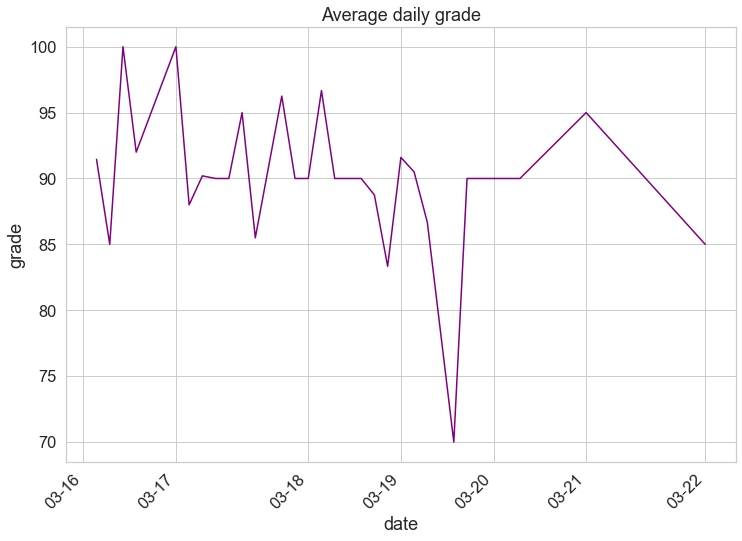

In [12]:
reviews['date'] = pd.to_datetime(reviews['date'])
reviews.index = reviews['date'] 

fig, ax = plt.subplots(figsize=(12, 8))


mean_daily_grades = reviews.resample('D', on='date').mean().reset_index('date')


# Plot horizontal bar graph
monthly_plot = sns.lineplot(data = mean_daily_grades,
                      x = 'date',
                      y = 'grade',
                      color="purple"
                      )

ax.set_title("Average daily grade")
x_dates = mean_daily_grades['date'].dt.strftime('%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

plt.show()

It looks like reviews started off pretty positively and declined steeply after which the average has been bouncing between 2 and almost 7. I could look at more distributions and things, but I won't for now. Mostly because I'd much prefer to use ggplot2 in R. :)

In [13]:
# Divide reviews into positive and negative based on the median grade for the dataset
median_grade = reviews.grade.median()

reviews.loc[reviews['grade'] <= median_grade, 'review_category'] = 'Negative' 
reviews.loc[reviews['grade'] > median_grade, 'review_category'] = 'Positive' 

reviews_neg = reviews[reviews['review_category'] == 'Negative']
reviews_pos = reviews[reviews['review_category'] == 'Positive']

In [18]:
texts = reviews['text'].tolist()
texts_neg = reviews_neg['text'].tolist()
texts_pos = reviews_pos['text'].tolist()

I learned how to clean the review text data and calculate frequencies using [this tutorial](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/). The next few cells will clean and prepare the data by removing punctuation, stop words, change everything to lower case, etc so we can calculate frequencies.

In [21]:
# We will want to remove stop words
stop_words = set(stopwords.words('english'))

In [22]:
def remove_punctuation(doc):
    """Replace URLs and other punctuation found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    doc : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with URLs and punctuation removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", doc).split())

In [23]:
def clean_text(docs):
    """Removes punctuation, changes to lowercase, removes
        stopwords, removes "animal" and "crossing", and
        calculates word frequencies.

    Parameters
    ----------
    docs : 待处理的文档列表

    Returns
    -------
    Words and frequencies
    """
    
    docs = [remove_punctuation(doc) for doc in docs]
    docs = [doc.lower().split() for doc in docs]
    
    docs = [[w for w in doc if not w in stop_words]
              for doc in docs]
    docs = [[w for w in doc if not w in ['animal', 'crossing']]
                     for doc in docs]
    
    tmp = list(itertools.chain(*docs))
    tmp = collections.Counter(tmp)
        
    return tmp

In [44]:
docss = [d.split(' ') for d in texts_neg]
collections.Counter(list(itertools.chain(*docss)))

Counter({'Animal': 69,
         'Crossing:': 30,
         'New': 65,
         'Horizons': 55,
         'is': 67,
         'beautiful': 2,
         'and': 120,
         'peaceful,': 1,
         'offering': 2,
         'safe': 1,
         'harbour': 1,
         'from': 13,
         'the': 167,
         'stresses': 1,
         'of': 90,
         'everyday': 1,
         'life.': 2,
         'There’s': 3,
         'so': 20,
         'much': 16,
         'to': 116,
         'do': 11,
         'see,': 1,
         'what’s': 2,
         'wrong': 1,
         'with': 34,
         'making': 2,
         'a': 112,
         'back': 9,
         'seat?': 1,
         'With': 7,
         'fully': 3,
         'customizable': 2,
         'gameplay': 5,
         'game': 31,
         'experience': 4,
         'that': 48,
         'changes': 1,
         'daily,': 1,
         'Crossing': 36,
         'perfect': 6,
         'companion': 2,
         'for': 41,
         'dream': 2,
         'Having': 1,
         

In [24]:
# Clean up the review texts
clean_texts_neg = clean_text(texts_neg)
clean_texts_pos = clean_text(texts_pos)

## Plot data in a boring way

First, I thought it would be interesting to make more boring graphs of the data to compare to the cool ones with Shifterator.

In [28]:
# Dataframes for most frequent common words in positive and negative reviews
common_neg = pd.DataFrame(clean_texts_neg.most_common(15),
                             columns=['words', 'count'])

common_pos = pd.DataFrame(clean_texts_pos.most_common(15),
                             columns=['words', 'count'])

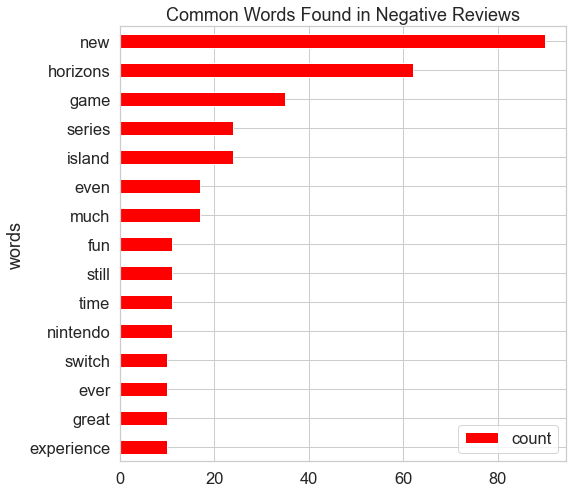

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
common_neg.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="red")

ax.set_title("Common Words Found in Negative Reviews")

plt.show()

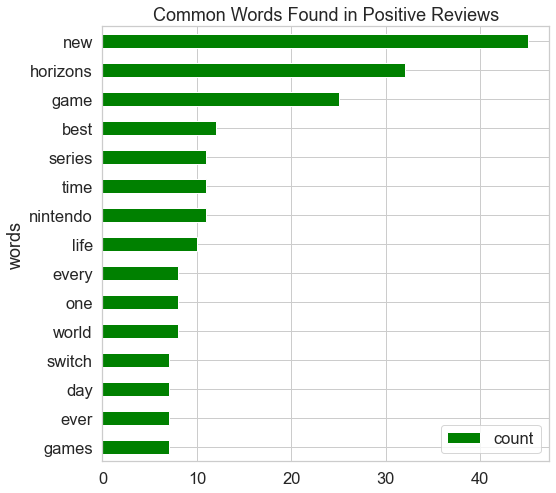

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
common_pos.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="green")

ax.set_title("Common Words Found in Positive Reviews")

plt.show()

Yes, these plots are very boring. Common words between negative and positive reviews are pretty similar. For something a bit more nuanced I'd normally look to calculate something like tf-idf, but again, [I'd be a lot more at home doing that in R with TidyText](https://www.tidytextmining.com/tfidf.html). Tf-idf would tell you more about a words' relative importance in a corpus taking frequency into account.

Okay, thought you'd get away without seeing a word cloud? Not so fast. ;) Let's do one for good measure. I'll spare you and just plot one for the negative reviews.

In [32]:
# From https://www.kaggle.com/prakashsadashivappa/word-cloud-of-abstracts-cord-19-dataset
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    ).generate(str(texts_neg))

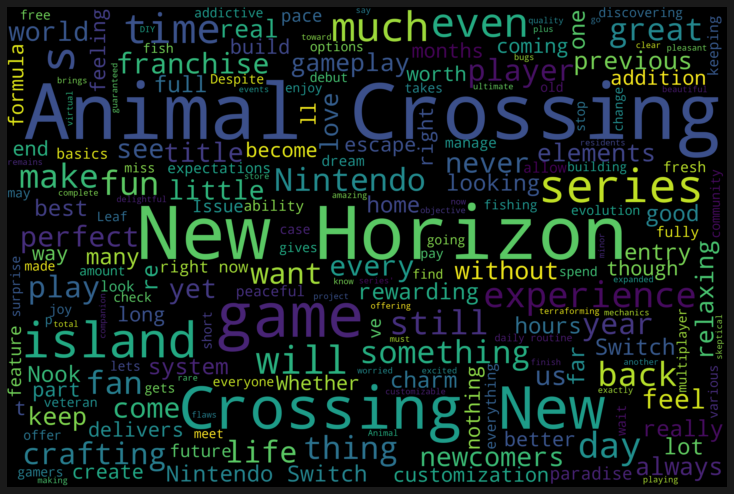

In [33]:
fig = plt.figure(
    figsize = (10, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Create word shift graphs with Shifterator

Time to finally use the Shifterator package! We could compare negative and positive Animal Crossing reviews based on both frequency and sentiment (or other values) using this package, but I've only calculated frequencies, so we'll just try plotting that.


### Entropy shift

The first graph is an entropy shift graph. [See the GitHub repo for more details](https://github.com/ryanjgallagher/shifterator#entropy-and-kullback-leibler-divergence-shifts).

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


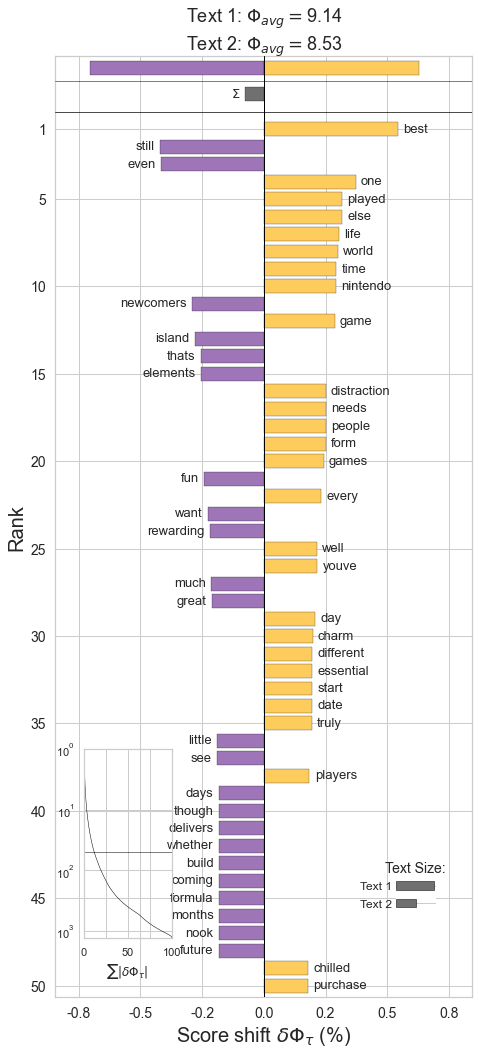

<AxesSubplot:title={'center':'Text 1: $\\Phi_{avg}=$9.14\nText 2: $\\Phi_{avg}=$8.53'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [37]:
# Get an entropy shift
from shifterator import EntropyShift
entropy_shift = EntropyShift(type2freq_1=clean_texts_neg,
                             type2freq_2=clean_texts_pos,
                             base=2)
entropy_shift.get_shift_graph() 

It looks like the negative reviews are in purple and positive ones are in yellow. It looks like feedback about the whole "one island per Switch" dominates. Fortunately my husband doesn't play so we don't have to deal with that. I wonder if "fix", "ridiculous", "experience" refers to some of the goofy, clunky UX. At least I think it's pretty goofy and clunky. A lot of the words are nouns and verbs like "console", "family", "money", "fix", "save".

Among the positive reviews, there are more adjectives pulled out. For example, "best", "fun", "amazing", "relaxing, "perfect". I wonder what "bombing" refers to in the positive reviews?

### Jensen-Shannon divergence shifts

The second graph is an Jensen-Shannon divergence shift graph. [See the GitHub repo for more details](https://github.com/ryanjgallagher/shifterator#jensen-shannon-divergence-shifts).

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


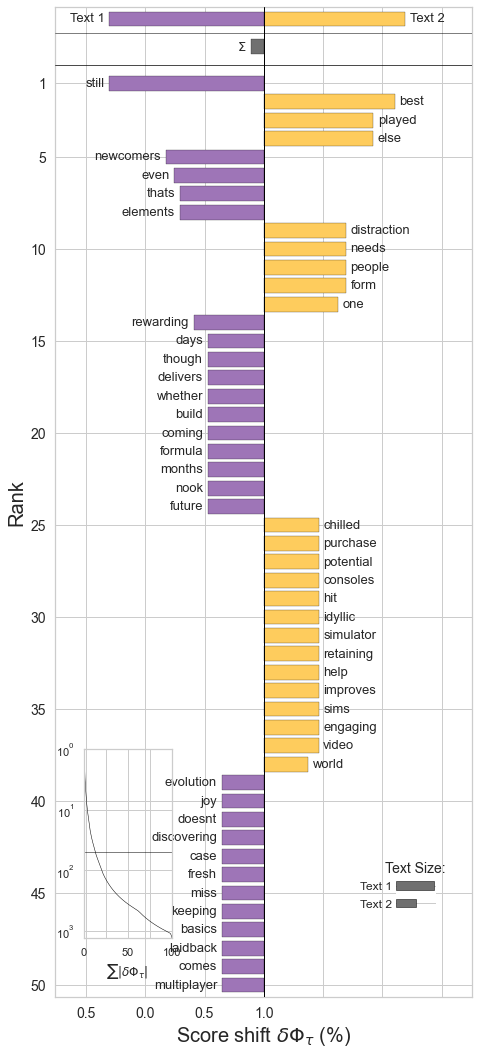

<AxesSubplot:xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [39]:
# Get a Jensen-Shannon divergence shift
from shifterator import JSDivergenceShift
jsd_shift = JSDivergenceShift(type2freq_1=clean_texts_neg,
                              type2freq_2=clean_texts_pos,
                              base=2)

jsd_shift.get_shift_graph()

Hmm, apart from the negative and positive reviews switching places, I don't have too much more to add to this plot. This analysis pulls out slightly different words and rankings.

## Conclusion

I hope this wasn't too painful to read for my Pythonista friends. I had fun checking out the new Shifterator package and I'm looking forward to digging into it in greater depth. It definitely seems much more promising than a word cloud, to say the least. If you fork this notebook and do something cool to extend and improve this analysis (especially if you add sentiment scores), let me know in the comments! Thanks again to Ryan Gallagher for [Shifterator](https://github.com/ryanjgallagher/shifterator).


<img src=Python专栏课.jpg width="30%">